In [1]:
import os
import pandas as pd
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load Data from csv

The dataset I have chosen to use is the [Facebook Large Page-Page Network dataset](https://snap.stanford.edu/data/facebook-large-page-page-network.html). It contains 22,470 Facebook pages classified into one of four classes, and there are 171,002 links in the network. Each page is represented by a vector of features.

The dataset has three separate files:
1. `musae_facebook_edges.csv`: This file contains the graph with two columns:
  - `id_1`: target node
  - `id_2`: source node
2. `musae_facebook_target.csv`: This file contains the descriptions and page type (label) of the 22,470 Facebook pages:
  - `id`
  - `facebook_id`
  - `page_name`: description
  - `page_type`: multi-class label (4 classes) that we're trying to predict.
3. `musae_facebook_features.json`: This file contains feature vectors for each Facebook page.

## Download Data

In [3]:
import urllib.request
import zipfile
import json
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops

In [4]:
url = "https://snap.stanford.edu/data/facebook_large.zip"
save_path = "./data/facebook_large.zip"
data_dir = "./data/facebook_large"

os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [5]:
# Download file
urllib.request.urlretrieve(url, save_path)

('./data/facebook_large.zip', <http.client.HTTPMessage at 0x7a8c7162ea10>)

In [6]:
# Extract file
with zipfile.ZipFile(save_path, "r") as zip_ref:
  zip_ref.extractall(path=os.path.dirname(save_path))

## EDA on Dataset

In [34]:
# Import edges file as a dataframe
df_edges = pd.read_csv(
    os.path.join(data_dir, "musae_facebook_edges.csv"),
).rename(columns={"id_1": "fb_site_id", "id_2": "follower_fb_site_id"})

print(df_edges.shape)
df_edges.head()

(171002, 2)


,fb_site_id,follower_fb_site_id
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [35]:
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171002 entries, 0 to 171001
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   fb_site_id           171002 non-null  int64
 1   follower_fb_site_id  171002 non-null  int64
dtypes: int64(2)
memory usage: 2.6 MB


In [28]:
# Import target dataframe
df_target = pd.read_csv(
    os.path.join(data_dir, "musae_facebook_target.csv"),
)

print(df_target.shape)
df_target.head()

(22470, 4)


,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [29]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22470 entries, 0 to 22469
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           22470 non-null  int64 
 1   facebook_id  22470 non-null  int64 
 2   page_name    22470 non-null  object
 3   page_type    22470 non-null  object
dtypes: int64(2), object(2)
memory usage: 702.3+ KB


In [36]:
# Check number of unique nodes in df_edges
len(set(df_edges.fb_site_id.tolist() + df_edges.follower_fb_site_id.tolist()))

22470

In [31]:
df_agg_classes = pd.DataFrame(df_target.page_type.value_counts(normalize=True)).reset_index()
df_agg_classes

,page_type,proportion
0,government,0.306186
1,company,0.289052
2,politician,0.256698
3,tvshow,0.148064


In [32]:
[i for i in df_agg_classes["proportion"].values]

[0.30618602581219406,
 0.2890520694259012,
 0.25669781931464175,
 0.14806408544726302]

Text(0.5, 1.0, '% of Users by Label')

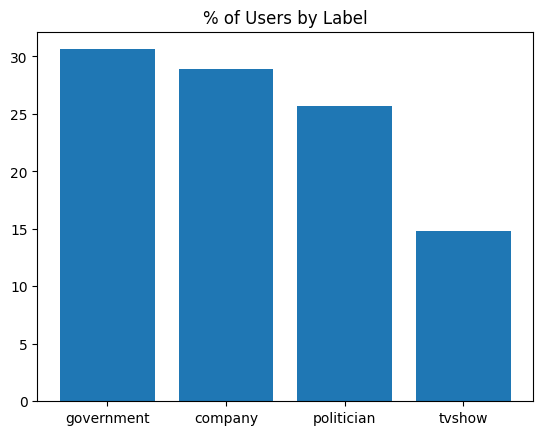

In [33]:
plt.bar(
    x=df_agg_classes.page_type.astype(str),
    height=df_agg_classes.proportion.apply(lambda x: x * 100)
)
plt.title("% of Users by Label")

In [15]:
# Import features
with open(os.path.join(data_dir, "musae_facebook_features.json"), "r") as json_file:
  features_data = json.load(json_file)

In [16]:
embeddings_len = {}

for node_id, embeddings in features_data.items():
  length = len(embeddings)
  count = embeddings_len.get(length, 0)
  count += 1
  embeddings_len[length] = count

Text(0.5, 1.0, 'Vector Size of Embeddings in features JSON file')

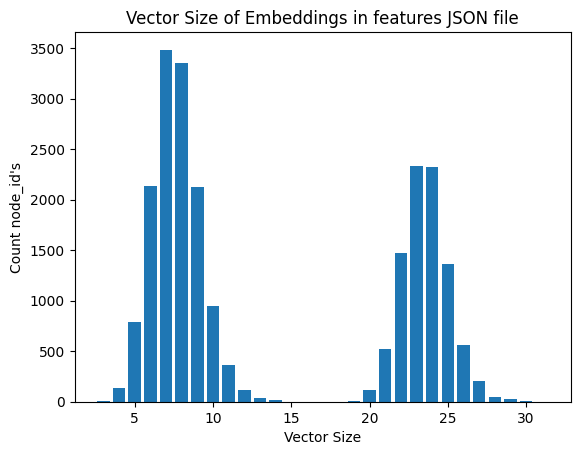

In [17]:
plt.bar(x=embeddings_len.keys(), height=embeddings_len.values())
plt.xlabel("Vector Size")
plt.ylabel("Count node_id's")
plt.title("Vector Size of Embeddings in features JSON file")

# Create PyTorch `Data` Object from CSV

In [7]:
from torch.nn.utils.rnn import pad_sequence

In [8]:
def load_node_csv(path, index_col, **kwargs):
  df = pd.read_csv(path, **kwargs)
  mapping = {i: node_id for i, node_id in enumerate(df[index_col].unique())}

  # Load node features
  with open(os.path.join(data_dir, "musae_facebook_features.json"), "r") as json_file:
    features_data = json.load(json_file)

  xs = []
  for index, node_id in mapping.items():
    features = features_data.get(str(index), [])
    if features:# Create tensor from feature vector
      features_tensor = torch.tensor(features, dtype=torch.float)
      xs.append(features_tensor)
    else:
      xs.append(torch.zeros(1, dtype=torch.float))

  # Pad features to have vectors of the same size
  padded_features = pad_sequence([torch.tensor(seq) for seq in xs], batch_first=True, padding_value=0)
  mask = padded_features != 0 # mask to indicate which features were padded

  # Create tensor of normaized features for nodes
  mean = torch.mean(padded_features[mask].float())
  std = torch.std(padded_features[mask].float())

  x = (padded_features - mean) / (std + 1e-8)  # final x tensor with normalized features

  return x

In [9]:
x = load_node_csv(path=os.path.join(data_dir, "musae_facebook_target.csv"), index_col="facebook_id")

<ipython-input-8-720dab76451b>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_features = pad_sequence([torch.tensor(seq) for seq in xs], batch_first=True, padding_value=0)


In [10]:
len(x)

22470

In [11]:
def load_labels_csv(path, label_col, **kwargs):
  df = pd.read_csv(path, **kwargs)

  # Convert class_labels to numeric data types in order to create tensors
  label_categories = df[label_col].astype("category").cat.categories

  class_label_to_code = pd.DataFrame({
      "class_label": label_categories,
      "class_label_code": pd.Categorical(label_categories, categories=label_categories).codes
  })
  df["class_label_code"] = pd.Categorical(df[label_col], categories=label_categories).codes

  y = torch.tensor(df["class_label_code"].values, dtype=torch.long)

  return y

In [12]:
y = load_labels_csv(path=os.path.join(data_dir, "musae_facebook_target.csv"), label_col="page_type")

In [13]:
len(y)

22470

In [14]:
def load_edge_csv(path, src_index_col, dst_index_col, **kwargs):
  df = pd.read_csv(path, **kwargs)

  src = df[src_index_col].values
  dst = df[dst_index_col].values
  edge_index = torch.tensor([src, dst])

  return edge_index

In [15]:
edge_index = load_edge_csv(path=os.path.join(data_dir, "musae_facebook_edges.csv"), src_index_col="id_1", dst_index_col="id_2")

<ipython-input-14-7854be74538a>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor([src, dst])


In [16]:
len(edge_index)

2

In [17]:
# Create homogeneous graph using PyTorch's Data object
data = Data(x=x, edge_index=edge_index, y=y)

print(data)

Data(x=[22470, 31], edge_index=[2, 171002], y=[22470])


# Train/ test Split

In [18]:
# Nodes
num_nodes = data.num_nodes
train_percentage = 0.7
num_train_nodes = int(train_percentage * num_nodes)

# labels
num_classes = torch.unique(data.y).size(0)
data.num_classes = num_classes

print("# of nodes: ", num_nodes, "\n# of train nodes: ", num_train_nodes, "\n# of classes: ", num_classes)

# of nodes:  22470 
# of train nodes:  15728 
# of classes:  4


In [19]:
# Create a boolean mask to indicate whether node is in training set
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[: num_train_nodes] = True

In [20]:
# Add train mask to data object
data.train_mask = train_mask

# Create test mask that is the inverse of train mask
test_mask = ~data.train_mask
data.test_mask = test_mask

data

Data(x=[22470, 31], edge_index=[2, 171002], y=[22470], num_classes=4, train_mask=[22470], test_mask=[22470])

## Train Multi-layer Perceptron Network (MLP)

In [21]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [22]:
# Helper function for visualization
def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(10, 10))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")

In [24]:

class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(123)
    self.lin1 = Linear(data.num_features, 32)
    self.lin2 = Linear(32, 32)
    self.lin3 = Linear(32, 16)
    self.lin4 = Linear(16, 8)
    self.lin5 = Linear(8, data.num_classes)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    x = F.relu(x)
    x = self.lin3(x)
    x = F.relu(x)
    x = self.lin4(x)
    x = F.relu(x)
    x = self.lin5(x)
    x = torch.softmax(x, dim=1)

    return x

In [37]:
class_weights = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)
class_weights

tensor([3.2660, 3.4596, 3.8956, 6.7538])

In [38]:
model = MLP()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(model)

MLP(
  (lin1): Linear(in_features=31, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=8, bias=True)
  (lin5): Linear(in_features=8, out_features=4, bias=True)
)


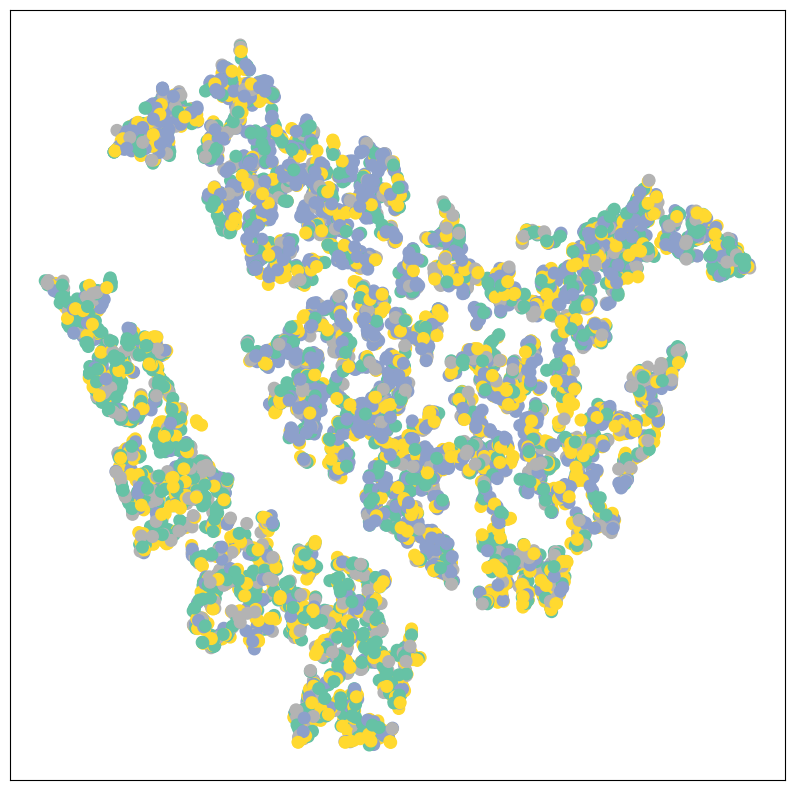

In [39]:
# Visualize nodes and labels before training
model.eval()
out = model(data.x)
visualize(out[data.test_mask], color=data.y[data.test_mask])

In [75]:
def train():
  model.train()
  optimizer.zero_grad()   # Clear gradients
  out = model(data.x)   # Perform a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask])   # Compute loss solely based on training nodes
  loss.backward()   # Derive gradients
  optimizer.step()    # Update parameters based on gradients
  return loss

In [76]:
def test():
  model.eval()
  out = model(data.x)
  pred = out.argmax(dim=1)  # Use class with highest probability

  # Count the number of predictions for each class
  class_counts = {}
  for class_label in range(data.num_classes):
      class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

  print(class_counts)

  test_correct = pred[data.test_mask] == data.y[data.test_mask]   # Check against ground-truth labels
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Calculate ratio of correct predictions
  return test_acc

In [77]:
for epoch in range(1, 1001):
  loss = train()
  if epoch % 10 == 0:
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 010, Loss: 1.3603
Epoch: 020, Loss: 1.3493
Epoch: 030, Loss: 1.3428
Epoch: 040, Loss: 1.3412
Epoch: 050, Loss: 1.3418
Epoch: 060, Loss: 1.3400
Epoch: 070, Loss: 1.3387
Epoch: 080, Loss: 1.3364
Epoch: 090, Loss: 1.3313
Epoch: 100, Loss: 1.3326
Epoch: 110, Loss: 1.3222
Epoch: 120, Loss: 1.3177
Epoch: 130, Loss: 1.3132
Epoch: 140, Loss: 1.3153
Epoch: 150, Loss: 1.3116
Epoch: 160, Loss: 1.3088
Epoch: 170, Loss: 1.3055
Epoch: 180, Loss: 1.3027
Epoch: 190, Loss: 1.3133
Epoch: 200, Loss: 1.3022
Epoch: 210, Loss: 1.2989
Epoch: 220, Loss: 1.2958
Epoch: 230, Loss: 1.2938
Epoch: 240, Loss: 1.2918
Epoch: 250, Loss: 1.2939
Epoch: 260, Loss: 1.2969
Epoch: 270, Loss: 1.2950
Epoch: 280, Loss: 1.2893
Epoch: 290, Loss: 1.2886
Epoch: 300, Loss: 1.2866
Epoch: 310, Loss: 1.2877
Epoch: 320, Loss: 1.2957
Epoch: 330, Loss: 1.2861
Epoch: 340, Loss: 1.2829
Epoch: 350, Loss: 1.2886
Epoch: 360, Loss: 1.2838
Epoch: 370, Loss: 1.2822
Epoch: 380, Loss: 1.2800
Epoch: 390, Loss: 1.2779
Epoch: 400, Loss: 1.2767


In [78]:
test_acc = test()
print(f"Test accuracy: {test_acc:.4f}")

{0: 1403, 1: 2755, 2: 1205, 3: 1379}
Test accuracy: 0.4562


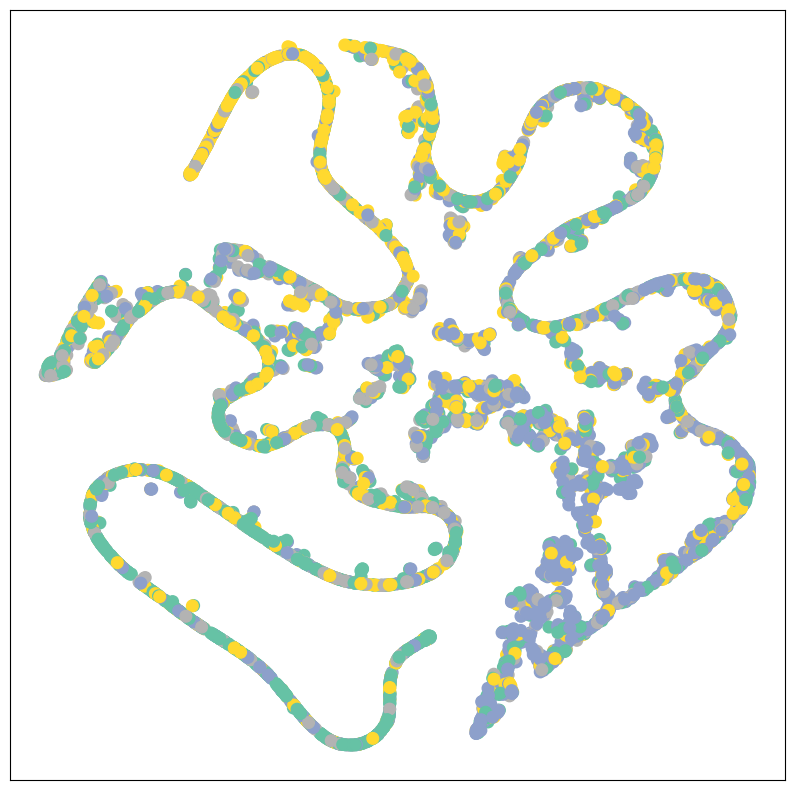

In [79]:
# Visualize nodes with MLP predictions
model.eval()
out = model(data.x)
visualize(out[data.test_mask], color=data.y[data.test_mask])

## Train Graph Neural Network (GNN)

In [43]:
from torch_geometric.nn import GCNConv

In [59]:
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(123)
    self.conv1 = GCNConv(data.num_features, 32)
    self.conv2 = GCNConv(32, 32)
    self.conv3 = GCNConv(32, 16)
    self.conv4 = GCNConv(16, 8)
    self.conv5 = GCNConv(8, data.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    # x = F.dropout(x, p=0.8)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    # x = F.dropout(x, p=0.8)
    x = self.conv3(x, edge_index)
    x = F.relu(x)
    x = self.conv4(x, edge_index)
    x = F.relu(x)
    x = self.conv5(x, edge_index)
    x = F.log_softmax(x, dim=1)
    return x

In [80]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(model)

GCN(
  (conv1): GCNConv(31, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 8)
  (conv5): GCNConv(8, 4)
)


In [81]:
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

In [82]:
def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)

  # Count the number of predictions for each class
  class_counts = {}
  for class_label in range(data.num_classes):
      class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

  print(class_counts)

  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc

In [83]:
for epoch in range(1, 1001):
  loss = train()
  if epoch % 10 == 0:
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 010, Loss: 1.3307
Epoch: 020, Loss: 1.2830
Epoch: 030, Loss: 1.2417
Epoch: 040, Loss: 1.2185
Epoch: 050, Loss: 1.1888
Epoch: 060, Loss: 1.1664
Epoch: 070, Loss: 1.1694
Epoch: 080, Loss: 1.1380
Epoch: 090, Loss: 1.1243
Epoch: 100, Loss: 1.1666
Epoch: 110, Loss: 1.1023
Epoch: 120, Loss: 1.0945
Epoch: 130, Loss: 1.0771
Epoch: 140, Loss: 1.0634
Epoch: 150, Loss: 1.0711
Epoch: 160, Loss: 1.0474
Epoch: 170, Loss: 1.0357
Epoch: 180, Loss: 1.0103
Epoch: 190, Loss: 1.0421
Epoch: 200, Loss: 1.0622
Epoch: 210, Loss: 1.0053
Epoch: 220, Loss: 0.9689
Epoch: 230, Loss: 0.9538
Epoch: 240, Loss: 0.9515
Epoch: 250, Loss: 0.9455
Epoch: 260, Loss: 0.9271
Epoch: 270, Loss: 0.9280
Epoch: 280, Loss: 0.9199
Epoch: 290, Loss: 0.9100
Epoch: 300, Loss: 0.9093
Epoch: 310, Loss: 0.9219
Epoch: 320, Loss: 1.0638
Epoch: 330, Loss: 0.9288
Epoch: 340, Loss: 0.8988
Epoch: 350, Loss: 0.8757
Epoch: 360, Loss: 0.8604
Epoch: 370, Loss: 0.8479
Epoch: 380, Loss: 0.8543
Epoch: 390, Loss: 0.8505
Epoch: 400, Loss: 0.8244


In [84]:
test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

{0: 1700, 1: 2078, 2: 1692, 3: 1272}
Test Accuracy: 0.7996


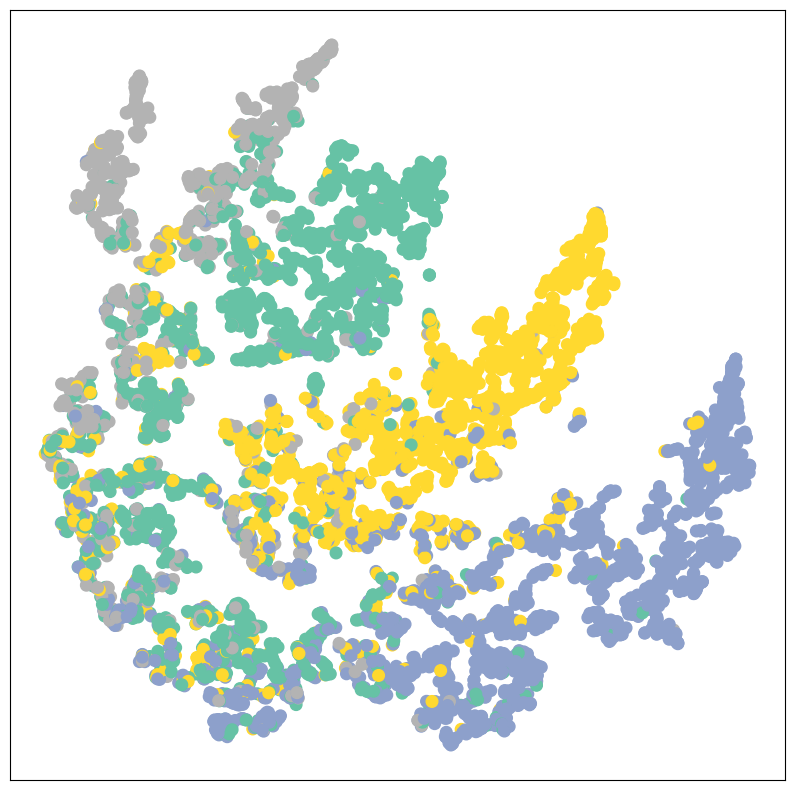

In [85]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

##Train a Graph Attention Network (GATConv)

In [51]:
from torch_geometric.nn import GATConv

In [52]:
class GAT(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(123)
    self.conv1 = GATConv(in_channels=data.num_features, out_channels=32, heads=32)
    self.conv2 = GATConv(in_channels=32 * 32, out_channels=16, heads=16)
    self.conv3 = GATConv(in_channels=16 * 16, out_channels=8, heads=8)
    self.conv4 = GATConv(in_channels=8 * 8, out_channels=4, heads=4)
    self.conv5 = GATConv(in_channels=4 * 4, out_channels=data.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)
    x = F.relu(x)
    x = self.conv4(x, edge_index)
    x = F.relu(x)
    x = self.conv5(x, edge_index)
    x = F.softmax(x, dim=1)
    return x

In [53]:
model = GAT()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

print(model)

GAT(
  (conv1): GATConv(31, 32, heads=32)
  (conv2): GATConv(1024, 16, heads=16)
  (conv3): GATConv(256, 8, heads=8)
  (conv4): GATConv(64, 4, heads=4)
  (conv5): GATConv(16, 4, heads=1)
)


In [54]:
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

In [55]:
def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)

  # Count the number of predictions for each class
  class_counts = {}
  for class_label in range(data.num_classes):
      class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

  print(class_counts)

  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc


In [56]:
for epoch in range(1, 101):
  loss = train()
  test_acc = test()
  print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}")

{0: 80, 1: 6473, 2: 189, 3: 0}
Epoch: 001, Loss: 1.3825, Test: 0.3134
{0: 0, 1: 0, 2: 6742, 3: 0}
Epoch: 002, Loss: 1.4019, Test: 0.2523
{0: 208, 1: 1411, 2: 5123, 3: 0}
Epoch: 003, Loss: 1.4380, Test: 0.3150
{0: 927, 1: 5038, 2: 777, 3: 0}
Epoch: 004, Loss: 1.3810, Test: 0.3738
{0: 1576, 1: 5166, 2: 0, 3: 0}
Epoch: 005, Loss: 1.3712, Test: 0.3962
{0: 1326, 1: 5301, 2: 115, 3: 0}
Epoch: 006, Loss: 1.3676, Test: 0.3856
{0: 1232, 1: 4855, 2: 654, 3: 1}
Epoch: 007, Loss: 1.3633, Test: 0.3977
{0: 1751, 1: 4184, 2: 791, 3: 16}
Epoch: 008, Loss: 1.3591, Test: 0.4115
{0: 1613, 1: 4379, 2: 269, 3: 481}
Epoch: 009, Loss: 1.3570, Test: 0.4175
{0: 1154, 1: 5023, 2: 37, 3: 528}
Epoch: 010, Loss: 1.3528, Test: 0.3931
{0: 1664, 1: 4490, 2: 68, 3: 520}
Epoch: 011, Loss: 1.3500, Test: 0.4195
{0: 1865, 1: 4212, 2: 99, 3: 566}
Epoch: 012, Loss: 1.3457, Test: 0.4306
{0: 1272, 1: 4843, 2: 27, 3: 600}
Epoch: 013, Loss: 1.3423, Test: 0.3994
{0: 2326, 1: 3737, 2: 72, 3: 607}
Epoch: 014, Loss: 1.3431, Test: 0

In [57]:
test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

{0: 1474, 1: 3073, 2: 1383, 3: 812}
Test Accuracy: 0.6006


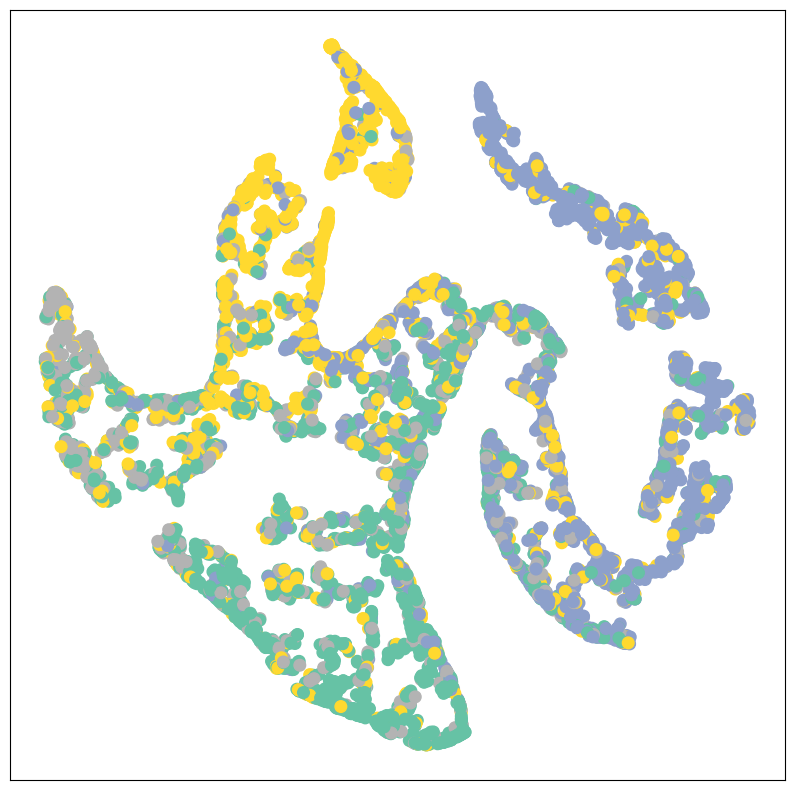

In [58]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])